# Convergence Time Study


## Motivation
We would like to see how the model's convergence time behaves in different types of networks.

### Experiment 1
We run the model on G(N, p) networks with maximum density of 0.1

### Experiment 2
We run the model on Chain Graphs.

### Experiment 3
We run the model on preferential attachment networks with maximum M eual to 0.1 * N.

In [3]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
from numpy import diag
import numpy.random as rand
from numpy.linalg import norm, inv, eigvals

import sys
from IPython import display
from tqdm import tqdm
from ipyparallel import Client

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, repeat
import pandas as pd

import models
from util import *
from viz import *
import networkx as nx
import time

sns.set_context('paper', font_scale=1.5)
sns.set_palette('colorblind')


In [2]:
v, dv = parallel_init('/home/user/opinions-research/', profile='ssh')

[*] 15 parallel engines available
[*] Finished setting working directories


In [4]:
def run_model(s):
    ''' Return convergence time
    '''
    import models
    t, z = models.hk_local_nomem(A, s, op_eps, max_rounds)
    return t

def list_stats(my_list):
    return '{0} values (min: {1}, max: {2})'.format(len(my_list), min(my_list), max(my_list))

# 1. G(N, p) Graphs

In [5]:
rand.seed(8925)

max_rounds = 10e3

# Generate values for N
N_list = xrange(256, 1025, 64)

# Generate values for ε
EPS_POINTS = 10
eps_list = np.linspace(1e-3, 0.4, EPS_POINTS)

# Number of different s values
SIM_NUM = 40

# Number of differnet p values for G(N, p)
P_POINTS = 10
P_MAX = 0.1

print('[+] N: {0}'.format(list_stats(N_list)))
print('[+] eps: {0}'.format(list_stats(eps_list)))
print('[+] s: {0} random values'.format(SIM_NUM))
print('[+] p: {0} values (max: {1})'.format(P_POINTS, P_MAX))

[+] N: 13 values (min: 256, max: 1024)
[+] eps: 10 values (min: 0.001, max: 0.4)
[+] s: 40 random values
[+] p: 10 values (max: 0.1)


In [ ]:
# Each row of result will contain
# N, p, eps, conv_time
result = np.empty((0, 4))
total_sims = len(N_list)*EPS_POINTS*P_POINTS
t = tqdm(total=total_sims)
dv.clear()
for N in N_list:
    # Create random opinions 
    s_list = [rand.rand(N) for _ in xrange(SIM_NUM)]
    # Lowest p value to prevent the creation of chain graphs
    P_MIN = np.log10(N)/N
    # Create p values
    p_list = np.linspace(P_MIN, P_MAX, P_POINTS)
    # Create networks
    network_list = [gnp(N, p, verbose=False) for p in p_list]
    for idx, A in enumerate(network_list):
        for eps in eps_list:
            t.update()
            ar = dv.push(dict(A=A, op_eps=eps, max_rounds=max_rounds))
            # Block until values are pushed
            ar.get()
            # Map
            res = parallel_map(v, run_model, s_list, silent=True)
            # Calcuate and save results
            avg_time = np.mean(res)
            res_row = np.array([N, p_list[idx], eps, avg_time])
            result = np.vstack((result, res_row))
t.close()

In [ ]:
df_gnp = pd.DataFrame(data=result, columns=['N', 'p', 'eps', 'convergence_time'])

In [ ]:
eps_range = pd.cut(df_gnp['eps'], 4, right=False, precision=3)
df_gnp['eps_range'] = eps_range
df_gnp['N'] = df_gnp['N'].astype(int)
df_gnp.to_csv('hk_local_convtimes_gnp2.csv')

In [6]:
df_gnp = pd.read_csv('hk_local_convtimes_gnp2.csv')

# 2. Chain Graphs

In [ ]:
def create_chain(N):
    A = np.zeros((N, N))
    for i in xrange(N):
        if i - 1 >= 0:
            A[i, i-1] = 1
        A[i, i] = 1
        if i + 1 < N:
            A[i, i+1] = 1
    return A

rand.seed(8925)

max_rounds = 50e3

# Generate values for N
N_list = xrange(256, 1025, 64)

# Generate values for ε
EPS_POINTS = 10
eps_list = np.linspace(1e-3, 0.4, EPS_POINTS)

# Number of different s values
SIM_NUM = 40

# Number of differnet p values for G(N, p)
P_POINTS = 10
P_MAX = 0.1

print('[+] N: {0}'.format(list_stats(N_list)))
print('[+] eps: {0}'.format(list_stats(eps_list)))
print('[+] s: {0} random values'.format(SIM_NUM))

In [ ]:
# Each row of result will contain
# N, eps, conv_time
result = np.empty((0, 3))
total_sims = len(N_list)*P_POINTS
t = tqdm(total=total_sims)
dv.clear()
for N in N_list:
    # Create random opinions 
    s_list = [rand.rand(N) for _ in xrange(SIM_NUM)]
    # Create network
    A = create_chain(N)
    ar = dv.push(dict(A=A, max_rounds=max_rounds))
    # Block until values are pushed
    ar.get()
    for eps in eps_list:
        t.update()
        ar = dv.push(dict(op_eps=eps))
        # Block until values are pushed
        ar.get()
        # Map
        res = parallel_map(v, run_model, s_list, silent=True)
        # Calcuate and save results
        avg_time = np.mean(res)
        res_row = np.array([N, eps, avg_time])
        result = np.vstack((result, res_row))
t.close()

In [ ]:
df_chain = pd.DataFrame(data=result, columns=['N', 'eps', 'convergence_time'])

In [ ]:
eps_range = pd.cut(df_chain['eps'], 4, right=False, precision=3)
df_chain['eps_range'] = eps_range
df_chain['N'] = df_chain['N'].astype(int)

In [ ]:
df_chain.to_csv('hk_local_convtimes_chain.csv')

In [26]:
df_chain = pd.read_csv('hk_local_convtimes_chain.csv', index_col=2)

# 3. Barabasi-Albert (Scale free) Graphs

In [68]:
rand.seed(8925)

max_rounds = 20e3

# Generate values for N
N_list = np.array(xrange(256, 1025, 64))

# Generate values for ε
EPS_POINTS = 10
eps_list = np.linspace(1e-3, 0.4, EPS_POINTS)

# Number of different s values
SIM_NUM = 40

# Number of differnet p values for G(N, p)
M_POINTS = 10
M_MIN = 2
print('[+] N: {0}'.format(list_stats(N_list)))
print('[+] eps: {0}'.format(list_stats(eps_list)))
print('[+] M: {0} values (min: {1})'.format(P_POINTS, M_MIN))
print('[+] s: {0} random values'.format(SIM_NUM))

[+] N: 13 values (min: 256, max: 1024)
[+] eps: 10 values (min: 0.001, max: 0.4)
[+] M: 10 values (min: 2)
[+] s: 40 random values


In [ ]:
# Each row of result will contain
# N, M, eps, conv_time
result = np.empty((0, 4))
total_sims = len(N_list)*EPS_POINTS*M_POINTS
t = tqdm(total=total_sims)
dv.clear()
for N in N_list:
    # Create random opinions 
    s_list = [rand.rand(N) for _ in xrange(SIM_NUM)]
    M_thres = N // 10
    # Create p values
    M_list = np.linspace(2, M_thres, M_POINTS)
    # Create networks
    network_list = [barabasi_albert(N, int(round(M)), None, verbose=False) for M in M_list]
    for idx, A in enumerate(network_list):
        for eps in eps_list:
            t.update()
            ar = dv.push(dict(A=A, op_eps=eps, max_rounds=max_rounds))
            # Block until values are pushed
            ar.get()
            # Map
            res = parallel_map(v, run_model, s_list, silent=True)
            # Calcuate and save results
            avg_time = np.mean(res)
            res_row = np.array([N, int(round(M_list[idx])), eps, avg_time])
            result = np.vstack((result, res_row))
t.close()

In [ ]:
df_barabasi = pd.DataFrame(data=result, columns=['N', 'M', 'eps', 'convergence_time'])

In [ ]:
eps_range = pd.cut(df_barabasi['eps'], 4, right=False, precision=3)
df_barabasi['eps_range'] = eps_range
df_barabasi['N'] = df_barabasi['N'].astype(int)

In [ ]:
df_barabasi.to_csv('hk_local_convtimes_barabasi.csv')

# Concatenate dataframes and plot

In [6]:
df_gnp = pd.read_csv('hk_local_convtimes_gnp2.csv')
df_barabasi = pd.read_csv('hk_local_convtimes_barabasi.csv')
df_barabasi['network'] = 'Barabasi-Albert'
df_gnp['network'] = 'G(N, p)'
df = pd.concat((df_gnp, df_barabasi))

/home/user/opinions-research/env/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


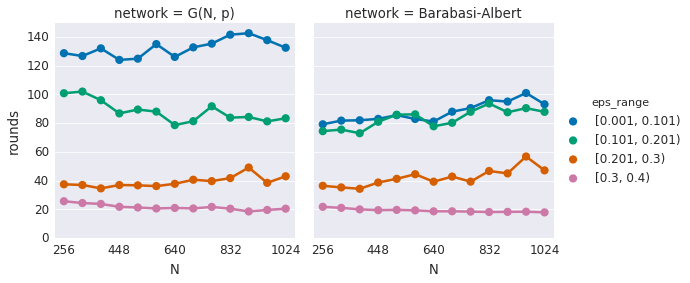

In [5]:
N_list = np.array(N_list)
g = sns.factorplot(x='N', y='convergence_time', data=df, hue='eps_range', col='network', ci=None)
plt.ylim(0, 150)
g.set_ylabels('rounds')

g.set(xticks=np.arange(0, len(N_list), 3))
g.set(xticklabels=N_list[0::3])
plt.show()

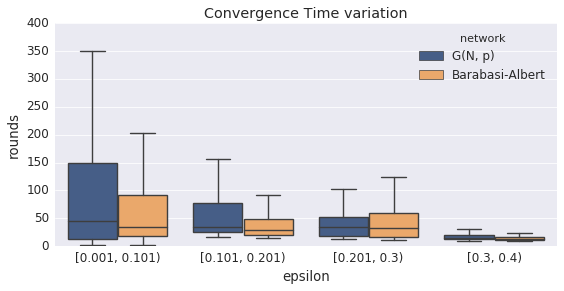

In [9]:
pal1 = sns.xkcd_palette(['denim blue', 'pale orange'])
sns.boxplot(y='convergence_time', x='eps_range', hue='network', data=df, orient='v', sym='', palette=pal1)
plt.xlabel('epsilon')
plt.ylabel('rounds')
plt.title('Convergence Time variation')
plt.ylim(0, 400)
fig = plt.gcf()
fig.set_size_inches(9, 4)
plt.show()